# 2kr Analysis

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]
intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## 2kr

In [8]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1.00000,0.999110,1.00000,1.000000,0.996441,1.000000,1.000000,0.997331,1.000000,0.999110,0.999199,0.000801,-0.000089,0.000801,0.000801,-2.758007e-03,0.000801,0.000801,-0.001868,0.000801,-0.000089
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,0.99911,1.000000,1.00000,0.995552,0.998221,1.000000,1.000000,0.995552,0.994662,0.999110,0.998221,0.000890,0.001779,0.001779,-0.002669,-1.110223e-16,0.001779,0.001779,-0.002669,-0.003559,0.000890
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,0.99911,1.000000,0.99911,1.000000,1.000000,0.998221,1.000000,1.000000,1.000000,0.999110,0.999555,-0.000445,0.000445,-0.000445,0.000445,4.448399e-04,-0.001335,0.000445,0.000445,0.000445,-0.000445
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,0.999110,1.000000,1.000000,1.000000,0.999911,0.000089,0.000089,0.000089,0.000089,8.896797e-05,0.000089,-0.000801,0.000089,0.000089,0.000089
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1.00000,0.996441,1.00000,0.998221,1.000000,0.999110,0.997331,0.996441,0.997331,1.000000,0.998488,0.001512,-0.002046,0.001512,-0.000267,1.512456e-03,0.000623,-0.001157,-0.002046,-0.001157,0.001512
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,1.00000,1.000000,1.00000,0.998221,1.000000,0.998221,0.999110,0.998221,1.000000,1.000000,0.999377,0.000623,0.000623,0.000623,-0.001157,6.227758e-04,-0.001157,-0.000267,-0.001157,0.000623,0.000623
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,0.99911,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.999110,0.999110,0.986655,0.998399,0.000712,0.001601,0.001601,0.001601,1.601423e-03,0.001601,0.001601,0.000712,0.000712,-0.011744
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999110,1.000000,0.999911,0.000089,0.000089,0.000089,0.000089,8.896797e-05,0.000089,0.000089,0.000089,-0.000801,0.000089
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1.00000,1.000000,0.99911,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999911,0.000089,0.000089,-0.000801,0.000089,8.896797e-05,0.000089,0.000089,0.000089,0.000089,0.000089


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.992438,0.006317,-0.000445,0.00258,0.002224,0.000979,-0.002402,-0.001335,-0.001335,0.002936,0.002046,0.001868,-0.003114,-0.001868,-0.001157,0.000267,0.003998,0.001332,0.004885,-0.001332,0.002221,0.003108,0.003109,-0.005774,-0.002219,-0.009327
Mean (Qi),0.999527,0.000395,-0.000028,0.000161,0.000139,0.000061,-0.00015,-0.000083,-0.000083,0.000183,0.000128,0.000117,-0.000195,-0.000117,-0.000072,0.000017,0.000250,0.000083,0.000305,-0.000083,0.000139,0.000194,0.000194,-0.000361,-0.000139,-0.000583
SSQ,,,,,,,,,,,,,,,,,0.000005,0.000013,0.000010,0.000012,0.000013,0.000010,0.000009,0.000017,0.000017,0.000142


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.000025,0.0,0.000004,0.000003,0.000001,0.000004,0.000001,0.000001,0.000005,0.000003,0.000002,0.000006,0.000002,0.000001,0.0,0.000249
Variation,0.081234,0.000403,0.013552,0.010072,0.00195,0.011748,0.003626,0.003626,0.017549,0.008525,0.007107,0.019741,0.007107,0.002723,0.000145,0.000307
Variation%,8.12%,0.04%,1.36%,1.01%,0.19%,1.17%,0.36%,0.36%,1.75%,0.85%,0.71%,1.97%,0.71%,0.27%,0.01%,81.09%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),0.0006,0.000178,0.000367,0.000344,0.000267,0.000055,0.000122,0.000122,0.000389,0.000333,0.000322,0.000011,0.000089,0.000133,0.000222
CI- Qi (95.00%),0.000189,-0.000233,-0.000044,-0.000066,-0.000144,-0.000356,-0.000289,-0.000289,-0.000022,-0.000078,-0.000089,-0.0004,-0.000322,-0.000278,-0.000189
Distance (Qi),0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411
Zero Included,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.187785,0.016449,0.070087,0.061843,0.037049,0.001595,0.007763,0.007763,0.078847,0.057914,0.054115,0.000061,0.004099,0.009243,0.025718
CI- Variation,0.018685,0.028357,0.001018,0.002301,0.010851,0.065901,0.043489,0.043489,0.000251,0.003136,0.004099,0.08342,0.054115,0.040205,0.018573
CI Distance (Variation),0.1691,0.011908,0.069069,0.059542,0.026199,0.064306,0.035725,0.035725,0.078596,0.054779,0.050016,0.083359,0.050016,0.030962,0.007145


SSE = 0.00024893618368561864
SST = 0.00030698996181658815
Error variance = 1.728723497816796e-06
Unexplained Variation = 81.09%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,750.0,749.0,652.0,618.0,585.0,695.0,620.0,695.0,764.0,686.0,681.4,68.6,67.6,-29.4,-63.4,-96.4,13.6,-61.4,13.6,82.6,4.6
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,474.0,391.0,387.0,402.0,440.0,440.0,470.0,459.0,466.0,390.0,431.9,42.1,-40.9,-44.9,-29.9,8.1,8.1,38.1,27.1,34.1,-41.9
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1116.0,1055.0,1081.0,1104.0,1140.0,1087.0,1098.0,1053.0,1179.0,1066.0,1097.9,18.1,-42.9,-16.9,6.1,42.1,-10.9,0.1,-44.9,81.1,-31.9
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,787.0,794.0,811.0,751.0,852.0,712.0,734.0,742.0,780.0,761.0,772.4,14.6,21.6,38.6,-21.4,79.6,-60.4,-38.4,-30.4,7.6,-11.4
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,704.0,609.0,789.0,671.0,638.0,585.0,572.0,709.0,614.0,660.0,655.1,48.9,-46.1,133.9,15.9,-17.1,-70.1,-83.1,53.9,-41.1,4.9
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,386.0,326.0,367.0,404.0,359.0,429.0,469.0,449.0,418.0,412.0,401.9,-15.9,-75.9,-34.9,2.1,-42.9,27.1,67.1,47.1,16.1,10.1
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1086.0,982.0,1080.0,1070.0,1075.0,1033.0,1111.0,990.0,1066.0,1030.0,1052.3,33.7,-70.3,27.7,17.7,22.7,-19.3,58.7,-62.3,13.7,-22.3
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,716.0,741.0,739.0,716.0,724.0,733.0,690.0,770.0,736.0,821.0,738.6,-22.6,2.4,0.4,-22.6,-14.6,-5.6,-48.6,31.4,-2.6,82.4
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,2663.0,2501.0,2886.0,2677.0,2752.0,2677.0,2485.0,2713.0,2404.0,3251.0,2700.9,-37.9,-199.9,185.1,-23.9,51.1,-23.9,-215.9,12.1,-296.9,550.1


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,34529.9,22866.9,-642.5,13086.5,-4640.9,-371.1,10104.7,-2357.1,258.1,-27.3,8.5,304.3,-43.5,281.5,-92.3,-123.3,-453337.710000,-2.553271e+06,4.025816e+06,-2.944793e+06,2.103254e+06,1.116921e+06,-2.929867e+06,718104.790000,-1.318602e+06,2.235775e+06
Mean (Qi),2158.11875,1429.18125,-40.15625,817.90625,-290.05625,-23.19375,631.54375,-147.31875,16.13125,-1.70625,0.53125,19.01875,-2.71875,17.59375,-5.76875,-7.70625,-28333.606875,-1.595794e+05,2.516135e+05,-1.840496e+05,1.314534e+05,6.980755e+04,-1.831167e+05,44881.549375,-8.241261e+04,1.397359e+05
SSQ,,,,,,,,,,,,,,,,,508472.610000,2.172694e+05,4.286094e+05,5.687216e+05,1.173610e+05,1.461236e+05,5.129890e+05,378935.610000,3.297188e+05,6.024618e+05


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,326809447.25625,258003.90625,107035301.40625,13461220.50625,86072.00625,63815601.30625,3472450.25625,41634.75625,465.80625,45.15625,57874.05625,1182.65625,49526.40625,5324.55625,9501.80625,3810662.9
Variation,0.629795,0.000497,0.206268,0.025941,0.000166,0.122979,0.006692,0.00008,0.000001,0.0,0.000112,0.000002,0.000095,0.00001,0.000018,518914314.74375
Variation%,62.98%,0.05%,20.63%,2.59%,0.02%,12.30%,0.67%,0.01%,0.00%,0.00%,0.01%,0.00%,0.01%,0.00%,0.00%,0.73%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),1454.601062,-14.736438,843.326062,-264.636438,2.226062,656.963562,-121.898938,41.551062,23.713562,25.951062,44.438562,22.701062,43.013562,19.651062,17.713562
CI- Qi (95.00%),1403.761438,-65.576062,792.486438,-315.476062,-48.613562,606.123938,-172.738562,-9.288562,-27.126062,-24.888562,-6.401062,-28.138562,-7.826062,-31.188562,-33.126062
Distance (Qi),50.839625,50.839625,50.839625,50.839625,50.839625,50.839625,50.839625,50.839625,50.839625,50.839625,50.839625,50.839625,50.839625,50.839625,50.839625
Zero Included,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True
CI+ Variation,0.652397,0.000067,0.219288,0.021594,0.000002,0.133078,0.004582,0.000532,0.000173,0.000208,0.000609,0.000159,0.00057,0.000119,0.000097
CI- Variation,0.60759,0.001326,0.193646,0.030687,0.000729,0.113278,0.0092,0.000027,0.000227,0.000191,0.000013,0.000244,0.000019,0.0003,0.000338
CI Distance (Variation),0.044807,0.001259,0.025642,0.009094,0.000727,0.0198,0.004619,0.000506,0.000053,0.000017,0.000596,0.000085,0.000552,0.000181,0.000242


SSE = 3810662.9
SST = 518914314.74375
Error variance = 26462.936805555553
Unexplained Variation = 0.73%

####################################

2^k*r analysis for the total number of messages sent


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,793.0,790.0,745.0,757.0,736.0,780.0,719.0,758.0,761.0,759.0,759.8,33.2,30.2,-14.8,-2.8,-23.8,20.2,-40.8,-1.8,1.2,-0.8
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,713.0,693.0,683.0,682.0,686.0,713.0,723.0,694.0,717.0,686.0,699.0,14.0,-6.0,-16.0,-17.0,-13.0,14.0,24.0,-5.0,18.0,-13.0
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1124.0,1124.0,1124.0,1125.0,1125.0,1123.0,1125.0,1125.0,1124.0,1123.0,1124.2,-0.2,-0.2,-0.2,0.8,0.8,-1.2,0.8,0.8,-0.2,-1.2
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1124.0,1125.0,1125.0,1124.0,1125.0,1123.0,1123.0,1123.0,1125.0,1124.0,1124.1,-0.1,0.9,0.9,-0.1,0.9,-1.1,-1.1,-1.1,0.9,-0.1
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,749.0,713.0,766.0,759.0,730.0,724.0,727.0,740.0,733.0,755.0,739.6,9.4,-26.6,26.4,19.4,-9.6,-15.6,-12.6,0.4,-6.6,15.4
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,667.0,636.0,679.0,683.0,660.0,667.0,691.0,676.0,678.0,695.0,673.2,-6.2,-37.2,5.8,9.8,-13.2,-6.2,17.8,2.8,4.8,21.8
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1121.0,1120.0,1123.0,1124.0,1122.0,1121.0,1118.0,1121.0,1124.0,1106.0,1120.0,1.0,0.0,3.0,4.0,2.0,1.0,-2.0,1.0,4.0,-14.0
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1120.0,1113.0,1118.0,1119.0,1105.0,1109.0,1106.0,1107.0,1104.0,1121.0,1112.2,7.8,0.8,5.8,6.8,-7.2,-3.2,-6.2,-5.2,-8.2,8.8
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,520.0,509.0,586.0,537.0,546.0,527.0,536.0,577.0,505.0,625.0,546.8,-26.8,-37.8,39.2,-9.8,-0.8,-19.8,-10.8,30.2,-41.8,78.2


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,13547.4,-1156.8,-315.2,4098.0,-491.4,-191.0,880.2,-221.2,-25.0,-134.4,237.2,-84.8,-107.8,-1.4,-119.0,-114.8,76130.4400,-51669.76,56227.6400,-47054.3600,9817.34000,59306.74000,-82677.46000,-21436.86000,-96270.7600,97627.04
Mean (Qi),846.7125,-72.3,-19.7,256.125,-30.7125,-11.9375,55.0125,-13.825,-1.5625,-8.4,14.825,-5.3,-6.7375,-0.0875,-7.4375,-7.175,4758.1525,-3229.36,3514.2275,-2940.8975,613.58375,3706.67125,-5167.34125,-1339.80375,-6016.9225,6101.69
SSQ,,,,,,,,,,,,,,,,,4003.4600,6632.86,6671.0600,10136.0600,4399.66000,5643.86000,10009.26000,4124.06000,7017.8600,8163.26


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,836366.4,62094.4,10496002.5,150921.225,22800.625,484220.025,30580.9,390.625,11289.6,35164.9,4494.4,7263.025,1.225,8850.625,8236.9,66801.4
Variation,0.068412,0.005079,0.858535,0.012345,0.001865,0.039607,0.002501,0.000032,0.000923,0.002876,0.000368,0.000594,0.0,0.000724,0.000674,12225478.775
Variation%,6.84%,0.51%,85.85%,1.23%,0.19%,3.96%,0.25%,0.00%,0.09%,0.29%,0.04%,0.06%,0.00%,0.07%,0.07%,0.55%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-68.934382,-16.334382,259.490618,-27.346882,-8.571882,58.378118,-10.459382,1.803118,-5.034382,18.190618,-1.934382,-3.371882,3.278118,-4.071882,-3.809382
CI- Qi (95.00%),-75.665618,-23.065618,252.759382,-34.078118,-15.303118,51.646882,-17.190618,-4.928118,-11.765618,11.459382,-8.665618,-10.103118,-3.453118,-10.803118,-10.540618
Distance (Qi),6.731237,6.731237,6.731237,6.731237,6.731237,6.731237,6.731237,6.731237,6.731237,6.731237,6.731237,6.731237,6.731237,6.731237,6.731237
Zero Included,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
CI+ Variation,0.062191,0.003492,0.881247,0.009787,0.000962,0.044602,0.001432,0.000043,0.000332,0.004331,0.000049,0.000149,0.000141,0.000217,0.00019
CI- Variation,0.074929,0.006963,0.83612,0.015199,0.003065,0.034909,0.003868,0.000318,0.001812,0.001719,0.000983,0.001336,0.000156,0.001527,0.001454
CI Distance (Variation),0.012738,0.003471,0.045126,0.005411,0.002103,0.009693,0.002436,0.000275,0.00148,0.002612,0.000934,0.001187,0.000015,0.00131,0.001264


SSE = 66801.40000000001
SST = 12225478.774999997
Error variance = 463.89861111111117
Unexplained Variation = 0.55%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,78.0,62.0,70.0,55.0,50.0,58.0,53.0,52.0,52.0,54.0,58.4,19.6,3.6,11.6,-3.4,-8.4,-0.4,-5.4,-6.4,-6.4,-4.4
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,61.0,94.0,71.0,76.0,70.0,78.0,77.0,62.0,60.0,74.0,72.3,-11.3,21.7,-1.3,3.7,-2.3,5.7,4.7,-10.3,-12.3,1.7
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,84.0,63.0,64.0,62.0,61.0,54.0,60.0,69.0,73.0,69.0,65.9,18.1,-2.9,-1.9,-3.9,-4.9,-11.9,-5.9,3.1,7.1,3.1
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,59.0,65.0,91.0,81.0,74.0,70.0,74.0,61.0,69.0,66.0,71.0,-12.0,-6.0,20.0,10.0,3.0,-1.0,3.0,-10.0,-2.0,-5.0
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,119.0,90.0,92.0,91.0,94.0,109.0,93.0,105.0,127.0,108.0,102.8,16.2,-12.8,-10.8,-11.8,-8.8,6.2,-9.8,2.2,24.2,5.2
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,94.0,96.0,97.0,151.0,156.0,104.0,161.0,118.0,115.0,102.0,119.4,-25.4,-23.4,-22.4,31.6,36.6,-15.4,41.6,-1.4,-4.4,-17.4
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,112.0,95.0,92.0,91.0,89.0,106.0,127.0,175.0,164.0,90.0,114.1,-2.1,-19.1,-22.1,-23.1,-25.1,-8.1,12.9,60.9,49.9,-24.1
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,95.0,160.0,95.0,83.0,147.0,101.0,96.0,121.0,133.0,96.0,112.7,-17.7,47.3,-17.7,-29.7,34.3,-11.7,-16.7,8.3,20.3,-16.7
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,24.0,24.0,20.0,25.0,35.0,37.0,25.0,28.0,19.0,40.0,27.7,-3.7,-3.7,-7.7,-2.7,7.3,9.3,-2.7,0.3,-8.7,12.3


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,1005.2,-428.0,256.6,6.6,43.6,-106.2,-15.0,-24.8,-7.2,-0.6,-17.8,-4.0,7.0,35.8,-16.0,2.4,-1224.4400,-1266.640,-6746.4400,-3183.2400,3618.46000,-3584.14000,3961.66000,4714.7600,10112.46000,-6402.4400
Mean (Qi),62.825,-26.75,16.0375,0.4125,2.725,-6.6375,-0.9375,-1.55,-0.45,-0.0375,-1.1125,-0.25,0.4375,2.2375,-1.0,0.15,-76.5275,-79.165,-421.6525,-198.9525,226.15375,-224.00875,247.60375,294.6725,632.02875,-400.1525
SSQ,,,,,,,,,,,,,,,,,3537.4400,4182.840,3231.4400,3042.0400,4088.64000,910.84000,2766.24000,4357.0400,4187.64000,1689.4400


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,114490.0,41152.225,27.225,1188.1,7049.025,140.625,384.4,32.4,0.225,198.025,10.0,30.625,801.025,160.0,3.6,31993.6
Variation,0.579224,0.208196,0.000138,0.006011,0.035662,0.000711,0.001945,0.000164,0.000001,0.001002,0.000051,0.000155,0.004053,0.000809,0.000018,197661.1
Variation%,57.92%,20.82%,0.01%,0.60%,3.57%,0.07%,0.19%,0.02%,0.00%,0.10%,0.01%,0.02%,0.41%,0.08%,0.00%,16.19%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-24.420817,18.366683,2.741683,5.054183,-4.308317,1.391683,0.779183,1.879183,2.291683,1.216683,2.079183,2.766683,4.566683,1.329183,2.479183
CI- Qi (95.00%),-29.079183,13.708317,-1.916683,0.395817,-8.966683,-3.266683,-3.879183,-2.779183,-2.366683,-3.441683,-2.579183,-1.891683,-0.091683,-3.329183,-2.179183
Distance (Qi),4.658366,4.658366,4.658366,4.658366,4.658366,4.658366,4.658366,4.658366,4.658366,4.658366,4.658366,4.658366,4.658366,4.658366,4.658366
Zero Included,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.482747,0.273061,0.006085,0.020678,0.015025,0.001568,0.000491,0.002858,0.004251,0.001198,0.003499,0.006196,0.016881,0.00143,0.004975
CI- Variation,0.684484,0.152113,0.002974,0.000127,0.065082,0.008638,0.012181,0.006252,0.004534,0.009588,0.005385,0.002897,0.000007,0.008972,0.003844
CI Distance (Variation),0.201737,0.120948,0.003111,0.020551,0.050057,0.00707,0.011689,0.003394,0.000283,0.00839,0.001885,0.003299,0.016874,0.007542,0.001131


SSE = 31993.599999999995
SST = 197661.10000000003
Error variance = 222.17777777777775
Unexplained Variation = 16.19%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,130.0,105.0,124.0,94.0,80.0,95.0,80.0,79.0,84.0,84.0,95.5,34.5,9.5,28.5,-1.5,-15.5,-0.5,-15.5,-16.5,-11.5,-11.5
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,114.0,139.0,105.0,116.0,118.0,118.0,135.0,117.0,109.0,130.0,120.1,-6.1,18.9,-15.1,-4.1,-2.1,-2.1,14.9,-3.1,-11.1,9.9
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,128.0,104.0,95.0,105.0,100.0,101.0,104.0,115.0,114.0,105.0,107.1,20.9,-3.1,-12.1,-2.1,-7.1,-6.1,-3.1,7.9,6.9,-2.1
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,93.0,111.0,140.0,120.0,123.0,109.0,118.0,92.0,104.0,99.0,110.9,-17.9,0.1,29.1,9.1,12.1,-1.9,7.1,-18.9,-6.9,-11.9
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,203.0,142.0,150.0,137.0,155.0,183.0,144.0,154.0,200.0,187.0,165.5,37.5,-23.5,-15.5,-28.5,-10.5,17.5,-21.5,-11.5,34.5,21.5
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,182.0,145.0,176.0,232.0,246.0,167.0,243.0,214.0,174.0,161.0,194.0,-12.0,-49.0,-18.0,38.0,52.0,-27.0,49.0,20.0,-20.0,-33.0
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,183.0,160.0,150.0,167.0,127.0,184.0,184.0,257.0,243.0,149.0,180.4,2.6,-20.4,-30.4,-13.4,-53.4,3.6,3.6,76.6,62.6,-31.4
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,158.0,249.0,140.0,138.0,228.0,178.0,150.0,203.0,217.0,150.0,181.1,-23.1,67.9,-41.1,-43.1,46.9,-3.1,-31.1,21.9,35.9,-31.1
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,40.0,43.0,32.0,44.0,56.0,59.0,38.0,47.0,29.0,58.0,44.6,-4.6,-1.6,-12.6,-0.6,11.4,14.4,-6.6,2.4,-15.6,13.4


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,1625.5,-683.7,413.3,-13.3,81.5,-161.5,-22.1,-33.7,-9.5,7.7,-34.9,-8.7,6.1,62.3,-13.5,0.5,6970.690000,-3269.810000,-18315.810000,-8016.910000,6280.190000,-3596.510000,2425.390000,13971.990000,19419.590000,-15868.810000
Mean (Qi),101.59375,-42.73125,25.83125,-0.83125,5.09375,-10.09375,-1.38125,-2.10625,-0.59375,0.48125,-2.18125,-0.54375,0.38125,3.89375,-0.84375,0.03125,435.668125,-204.363125,-1144.738125,-501.056875,392.511875,-224.781875,151.586875,873.249375,1213.724375,-991.800625
SSQ,,,,,,,,,,,,,,,,,6483.210000,8645.210000,7125.210000,5420.410000,9429.210000,1690.610000,5127.810000,8058.610000,7912.410000,4676.210000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,292153.55625,106760.55625,110.55625,4151.40625,16301.40625,305.25625,709.80625,56.40625,37.05625,761.25625,47.30625,23.25625,2425.80625,113.90625,0.15625,64568.9
Variation,0.59803,0.218536,0.000226,0.008498,0.033369,0.000625,0.001453,0.000115,0.000076,0.001558,0.000097,0.000048,0.004966,0.000233,0.0,488526.59375
Variation%,59.80%,21.85%,0.02%,0.85%,3.34%,0.06%,0.15%,0.01%,0.01%,0.16%,0.01%,0.00%,0.50%,0.02%,0.00%,13.22%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-39.422349,29.140151,2.477651,8.402651,-6.784849,1.927651,1.202651,2.715151,3.790151,1.127651,2.765151,3.690151,7.202651,2.465151,3.340151
CI- Qi (95.00%),-46.040151,22.522349,-4.140151,1.784849,-13.402651,-4.690151,-5.415151,-3.902651,-2.827651,-5.490151,-3.852651,-2.927651,0.584849,-4.152651,-3.277651
Distance (Qi),6.617802,6.617802,6.617802,6.617802,6.617802,6.617802,6.617802,6.617802,6.617802,6.617802,6.617802,6.617802,6.617802,6.617802,6.617802
Zero Included,False,False,True,False,False,True,True,True,True,True,True,True,False,True,True
CI+ Variation,0.508999,0.278109,0.002011,0.023124,0.015077,0.001217,0.000474,0.002414,0.004705,0.000416,0.002504,0.00446,0.016991,0.00199,0.003654
CI- Variation,0.694233,0.166134,0.005614,0.001043,0.058832,0.007205,0.009604,0.004988,0.002619,0.009872,0.004861,0.002807,0.000112,0.005648,0.003518
CI Distance (Variation),0.185234,0.111975,0.003603,0.022081,0.043755,0.005988,0.00913,0.002574,0.002086,0.009455,0.002357,0.001653,0.016879,0.003658,0.000135


SSE = 64568.9
SST = 488526.59375000006
Error variance = 448.3951388888889
Unexplained Variation = 13.22%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,166.0,135.0,158.0,132.0,110.0,136.0,104.0,104.0,114.0,111.0,127.0,39.0,8.0,31.0,5.0,-17.0,9.0,-23.0,-23.0,-13.0,-16.0
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,153.0,192.0,142.0,160.0,159.0,165.0,175.0,152.0,148.0,173.0,161.9,-8.9,30.1,-19.9,-1.9,-2.9,3.1,13.1,-9.9,-13.9,11.1
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,164.0,139.0,131.0,138.0,135.0,136.0,138.0,147.0,153.0,145.0,142.6,21.4,-3.6,-11.6,-4.6,-7.6,-6.6,-4.6,4.4,10.4,2.4
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,126.0,150.0,177.0,162.0,163.0,153.0,155.0,126.0,147.0,146.0,150.5,-24.5,-0.5,26.5,11.5,12.5,2.5,4.5,-24.5,-3.5,-4.5
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,259.0,201.0,207.0,201.0,214.0,249.0,190.0,211.0,260.0,259.0,225.1,33.9,-24.1,-18.1,-24.1,-11.1,23.9,-35.1,-14.1,34.9,33.9
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,257.0,196.0,249.0,300.0,306.0,234.0,321.0,278.0,238.0,222.0,260.1,-3.1,-64.1,-11.1,39.9,45.9,-26.1,60.9,17.9,-22.1,-38.1
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,251.0,225.0,208.0,219.0,164.0,249.0,251.0,315.0,304.0,207.0,239.3,11.7,-14.3,-31.3,-20.3,-75.3,9.7,11.7,75.7,64.7,-32.3
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,215.0,317.0,184.0,203.0,285.0,256.0,211.0,280.0,290.0,203.0,244.4,-29.4,72.6,-60.4,-41.4,40.6,11.6,-33.4,35.6,45.6,-41.4
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,55.0,56.0,49.0,62.0,71.0,71.0,57.0,62.0,42.0,71.0,59.6,-4.6,-3.6,-10.6,2.4,11.4,11.4,-2.6,2.4,-17.6,11.4


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,2189.9,-911.9,561.1,-19.3,114.5,-212.7,-24.7,-51.3,-14.1,6.1,-34.3,-2.7,11.5,79.5,-1.5,4.3,8965.070000,-3356.830000,-30493.130000,-8056.930000,-1307.930000,5155.870000,4336.570000,16260.170000,28853.570000,-20356.430000
Mean (Qi),136.86875,-56.99375,35.06875,-1.20625,7.15625,-13.29375,-1.54375,-3.20625,-0.88125,0.38125,-2.14375,-0.16875,0.71875,4.96875,-0.09375,0.26875,560.316875,-209.801875,-1905.820625,-503.558125,-81.745625,322.241875,271.035625,1016.260625,1803.348125,-1272.276875
SSQ,,,,,,,,,,,,,,,,,7318.130000,11550.930000,10624.530000,5847.130000,11567.130000,2179.530000,7789.130000,9412.930000,9263.130000,6709.130000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,519726.00625,196770.75625,232.80625,8193.90625,28275.80625,381.30625,1644.80625,124.25625,23.25625,735.30625,4.55625,82.65625,3950.15625,1.40625,11.55625,82261.7
Variation,0.616944,0.233578,0.000276,0.009727,0.033565,0.000453,0.001952,0.000147,0.000028,0.000873,0.000005,0.000098,0.004689,0.000002,0.000014,842420.24375
Variation%,61.69%,23.36%,0.03%,0.97%,3.36%,0.05%,0.20%,0.01%,0.00%,0.09%,0.00%,0.01%,0.47%,0.00%,0.00%,9.76%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-53.258919,38.803581,2.528581,10.891081,-9.558919,2.191081,0.528581,2.853581,4.116081,1.591081,3.566081,4.453581,8.703581,3.641081,4.003581
CI- Qi (95.00%),-60.728581,31.333919,-4.941081,3.421419,-17.028581,-5.278581,-6.941081,-4.616081,-3.353581,-5.878581,-3.903581,-3.016081,1.233919,-3.828581,-3.466081
Distance (Qi),7.469661,7.469661,7.469661,7.469661,7.469661,7.469661,7.469661,7.469661,7.469661,7.469661,7.469661,7.469661,7.469661,7.469661,7.469661
Zero Included,False,False,True,False,False,True,True,True,True,True,True,True,False,True,True
CI+ Variation,0.538736,0.285979,0.001214,0.022529,0.017354,0.000912,0.000053,0.001547,0.003218,0.000481,0.002415,0.003767,0.014388,0.002518,0.003044
CI- Variation,0.700451,0.186475,0.004637,0.002223,0.055074,0.005292,0.009151,0.004047,0.002136,0.006564,0.002894,0.001728,0.000289,0.002784,0.002282
CI Distance (Variation),0.161715,0.099504,0.003423,0.020305,0.03772,0.00438,0.009097,0.0025,0.001082,0.006083,0.000479,0.002039,0.014098,0.000266,0.000763


SSE = 82261.70000000001
SST = 842420.2437500001
Error variance = 571.2618055555556
Unexplained Variation = 9.76%

####################################

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,180.0,157.0,179.0,155.0,137.0,162.0,122.0,121.0,132.0,135.0,148.0,32.0,9.0,31.0,7.0,-11.0,14.0,-26.0,-27.0,-16.0,-13.0
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,190.0,220.0,169.0,185.0,188.0,196.0,206.0,185.0,185.0,197.0,192.1,-2.1,27.9,-23.1,-7.1,-4.1,3.9,13.9,-7.1,-7.1,4.9
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,192.0,158.0,157.0,160.0,157.0,162.0,159.0,171.0,177.0,170.0,166.3,25.7,-8.3,-9.3,-6.3,-9.3,-4.3,-7.3,4.7,10.7,3.7
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,152.0,171.0,208.0,190.0,181.0,179.0,190.0,153.0,181.0,183.0,178.8,-26.8,-7.8,29.2,11.2,2.2,0.2,11.2,-25.8,2.2,4.2
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,300.0,244.0,245.0,240.0,266.0,288.0,226.0,255.0,299.0,297.0,266.0,34.0,-22.0,-21.0,-26.0,0.0,22.0,-40.0,-11.0,33.0,31.0
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,304.0,228.0,311.0,360.0,358.0,283.0,376.0,319.0,284.0,261.0,308.4,-4.4,-80.4,2.6,51.6,49.6,-25.4,67.6,10.6,-24.4,-47.4
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,287.0,272.0,262.0,251.0,196.0,283.0,299.0,352.0,348.0,245.0,279.5,7.5,-7.5,-17.5,-28.5,-83.5,3.5,19.5,72.5,68.5,-34.5
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,249.0,356.0,225.0,244.0,339.0,293.0,256.0,325.0,335.0,246.0,286.8,-37.8,69.2,-61.8,-42.8,52.2,6.2,-30.8,38.2,48.2,-40.8
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,66.0,69.0,58.0,75.0,83.0,88.0,69.0,73.0,49.0,88.0,71.8,-5.8,-2.8,-13.8,3.2,11.2,16.2,-2.8,1.2,-22.8,16.2


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,2589.1,-1062.7,666.1,-32.5,140.9,-244.9,-26.3,-71.7,-20.3,4.3,-41.5,5.9,18.1,91.9,-1.3,5.7,8267.550000,-9633.050000,-28286.950000,-9758.250000,1863.650000,3841.850000,8432.450000,16365.750000,36574.650000,-27667.650000
Mean (Qi),161.81875,-66.41875,41.63125,-2.03125,8.80625,-15.30625,-1.64375,-4.48125,-1.26875,0.26875,-2.59375,0.36875,1.13125,5.74375,-0.08125,0.35625,516.721875,-602.065625,-1767.934375,-609.890625,116.478125,240.115625,527.028125,1022.859375,2285.915625,-1729.228125
SSQ,,,,,,,,,,,,,,,,,8561.150000,13287.350000,10708.150000,7468.750000,13852.950000,2326.550000,9519.350000,9269.750000,10245.950000,8247.550000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,705832.05625,277305.75625,660.15625,12408.00625,37485.00625,432.30625,3213.05625,257.55625,11.55625,1076.40625,21.75625,204.75625,5278.50625,1.05625,20.30625,93487.5
Variation,0.620405,0.243743,0.00058,0.010906,0.032948,0.00038,0.002824,0.000226,0.00001,0.000946,0.000019,0.00018,0.00464,0.000001,0.000018,1137695.74375
Variation%,62.04%,24.37%,0.06%,1.09%,3.29%,0.04%,0.28%,0.02%,0.00%,0.09%,0.00%,0.02%,0.46%,0.00%,0.00%,8.22%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-62.43723,45.61277,1.95027,12.78777,-11.32473,2.33777,-0.49973,2.71277,4.25027,1.38777,4.35027,5.11277,9.72527,3.90027,4.33777
CI- Qi (95.00%),-70.40027,37.64973,-6.01277,4.82473,-19.28777,-5.62527,-8.46277,-5.25027,-3.71277,-6.57527,-3.61277,-2.85027,1.76223,-4.06277,-3.62527
Distance (Qi),7.963039,7.963039,7.963039,7.963039,7.963039,7.963039,7.963039,7.963039,7.963039,7.963039,7.963039,7.963039,7.963039,7.963039,7.963039
Zero Included,False,False,True,False,False,True,False,True,True,True,True,True,False,True,True
CI+ Variation,0.548253,0.292595,0.000535,0.022998,0.018036,0.000769,0.000035,0.001035,0.002541,0.000271,0.002661,0.003676,0.013301,0.002139,0.002646
CI- Variation,0.697016,0.199351,0.005084,0.003274,0.052319,0.00445,0.010072,0.003877,0.001939,0.00608,0.001836,0.001143,0.000437,0.002321,0.001848
CI Distance (Variation),0.148762,0.093244,0.00455,0.019724,0.034282,0.003682,0.010037,0.002842,0.000602,0.005809,0.000826,0.002534,0.012865,0.000182,0.000798


SSE = 93487.50000000001
SST = 1137695.7437499994
Error variance = 649.2187500000001
Unexplained Variation = 8.22%

####################################

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,207.0,168.0,194.0,167.0,148.0,173.0,133.0,132.0,140.0,146.0,160.8,46.2,7.2,33.2,6.2,-12.8,12.2,-27.8,-28.8,-20.8,-14.8
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,208.0,232.0,182.0,196.0,207.0,208.0,222.0,204.0,207.0,213.0,207.9,0.1,24.1,-25.9,-11.9,-0.9,0.1,14.1,-3.9,-0.9,5.1
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,205.0,173.0,166.0,179.0,171.0,175.0,176.0,187.0,187.0,180.0,179.9,25.1,-6.9,-13.9,-0.9,-8.9,-4.9,-3.9,7.1,7.1,0.1
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,162.0,181.0,225.0,202.0,198.0,186.0,200.0,166.0,193.0,193.0,190.6,-28.6,-9.6,34.4,11.4,7.4,-4.6,9.4,-24.6,2.4,2.4
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,335.0,261.0,270.0,273.0,292.0,304.0,245.0,273.0,329.0,314.0,289.6,45.4,-28.6,-19.6,-16.6,2.4,14.4,-44.6,-16.6,39.4,24.4
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,321.0,253.0,345.0,400.0,403.0,302.0,401.0,341.0,302.0,276.0,334.4,-13.4,-81.4,10.6,65.6,68.6,-32.4,66.6,6.6,-32.4,-58.4
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,306.0,291.0,278.0,278.0,207.0,316.0,308.0,372.0,376.0,277.0,300.9,5.1,-9.9,-22.9,-22.9,-93.9,15.1,7.1,71.1,75.1,-23.9
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,270.0,394.0,243.0,263.0,367.0,314.0,275.0,345.0,353.0,266.0,309.0,-39.0,85.0,-66.0,-46.0,58.0,5.0,-34.0,36.0,44.0,-43.0
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,74.0,74.0,66.0,80.0,88.0,90.0,75.0,76.0,56.0,93.0,77.2,-3.2,-3.2,-11.2,2.8,10.8,12.8,-2.2,-1.2,-21.2,15.8


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,2801.2,-1145.0,725.4,-44.6,148.4,-264.0,-20.0,-73.0,-26.4,7.8,-55.8,5.4,17.6,90.4,-6.4,-5.8,13242.66000,-9132.8400,-30910.74000,-3333.14000,7031.06000,918.960,3669.26000,14947.46000,38069.66000,-34502.34000
Mean (Qi),175.075,-71.5625,45.3375,-2.7875,9.275,-16.5,-1.25,-4.5625,-1.65,0.4875,-3.4875,0.3375,1.1,5.65,-0.4,-0.3625,827.66625,-570.8025,-1931.92125,-208.32125,439.44125,57.435,229.32875,934.21625,2379.35375,-2156.39625
SSQ,,,,,,,,,,,,,,,,,11098.34000,16056.3400,12651.14000,9087.94000,18882.54000,2647.740,9898.14000,8946.74000,11715.34000,8484.34000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,819390.625,328878.225,1243.225,13764.1,43560.0,250.0,3330.625,435.6,38.025,1946.025,18.225,193.6,5107.6,25.6,21.025,109468.6
Variation,0.617164,0.247711,0.000936,0.010367,0.032809,0.000188,0.002509,0.000328,0.000029,0.001466,0.000014,0.000146,0.003847,0.000019,0.000016,1327671.1
Variation%,61.72%,24.77%,0.09%,1.04%,3.28%,0.02%,0.25%,0.03%,0.00%,0.15%,0.00%,0.01%,0.38%,0.00%,0.00%,8.25%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-67.254092,49.645908,1.520908,13.583408,-12.191592,3.058408,-0.254092,2.658408,4.795908,0.820908,4.645908,5.408408,9.958408,3.908408,3.945908
CI- Qi (95.00%),-75.870908,41.029092,-7.095908,4.966592,-20.808408,-5.558408,-8.870908,-5.958408,-3.820908,-7.795908,-3.970908,-3.208408,1.341592,-4.708408,-4.670908
Distance (Qi),8.616817,8.616817,8.616817,8.616817,8.616817,8.616817,8.616817,8.616817,8.616817,8.616817,8.616817,8.616817,8.616817,8.616817,8.616817
Zero Included,False,False,True,False,False,True,False,True,True,True,True,True,False,True,True
CI+ Variation,0.545088,0.297027,0.000279,0.022236,0.017912,0.001127,0.000008,0.000852,0.002772,0.000081,0.002601,0.003525,0.011951,0.001841,0.001876
CI- Variation,0.693713,0.202868,0.006068,0.002973,0.05218,0.003723,0.009483,0.004278,0.001759,0.007324,0.0019,0.001241,0.000217,0.002672,0.002629
CI Distance (Variation),0.148625,0.094159,0.005789,0.019263,0.034268,0.002596,0.009476,0.003427,0.001012,0.007243,0.000701,0.002285,0.011734,0.000831,0.000753


SSE = 109468.6
SST = 1327671.1000000006
Error variance = 760.1986111111112
Unexplained Variation = 8.25%

####################################



## Performance plot

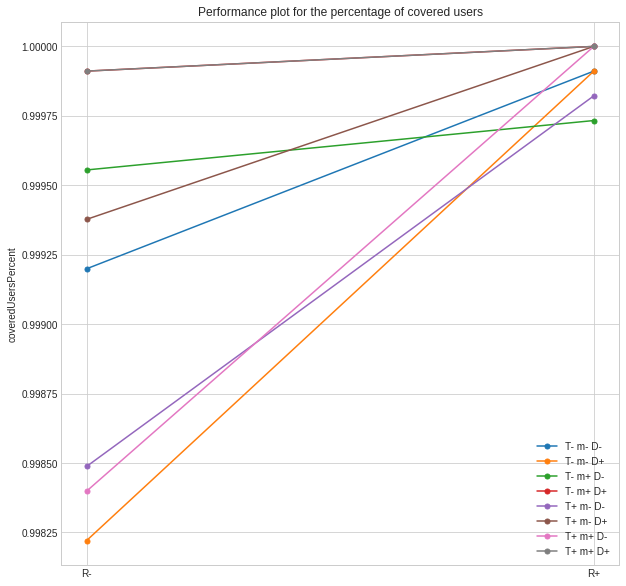

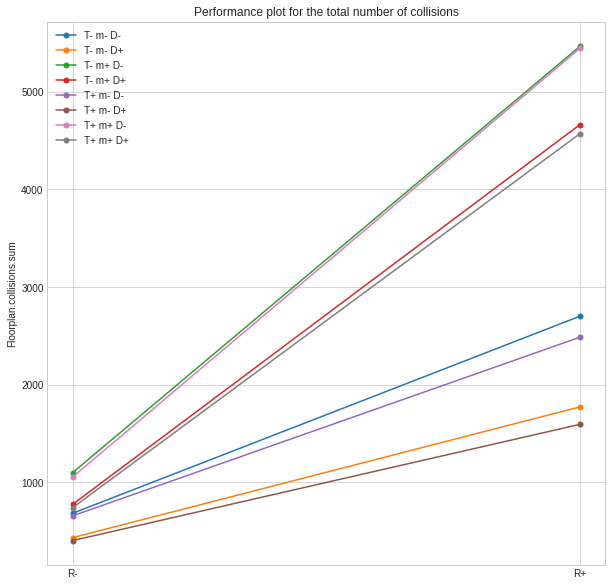

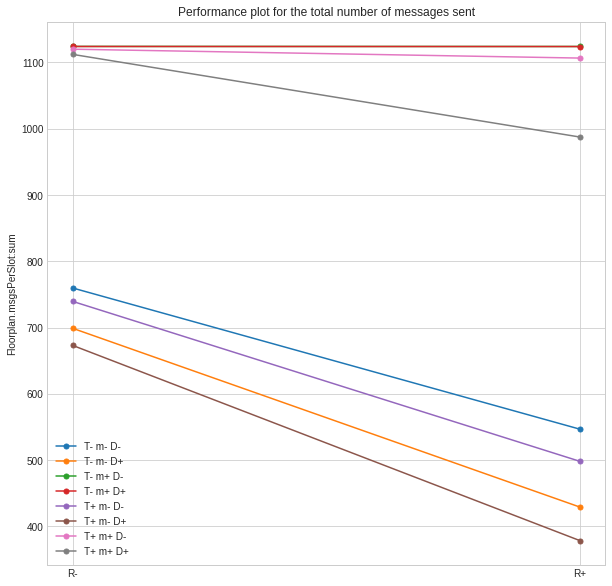

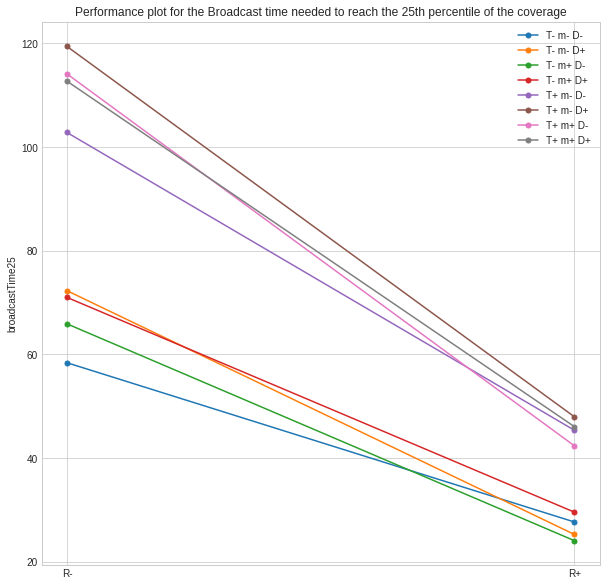

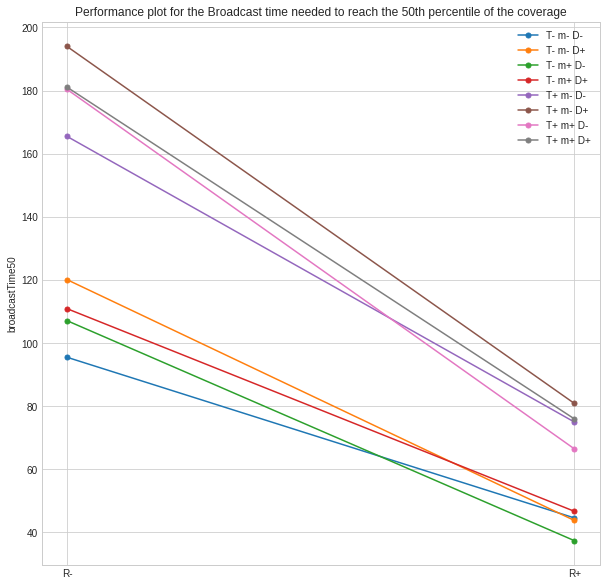

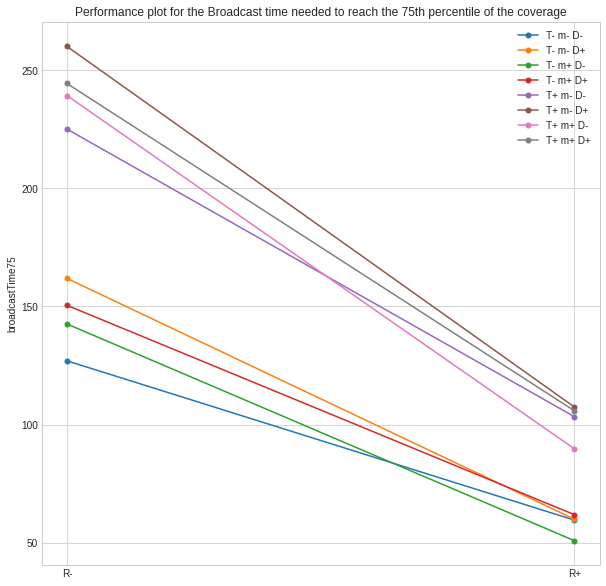

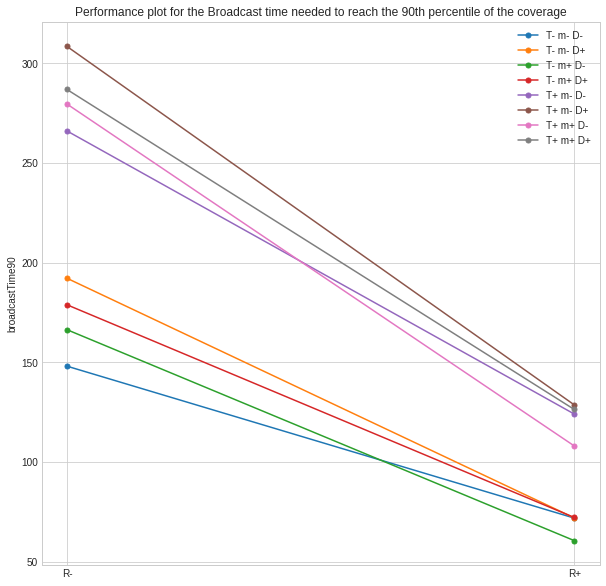

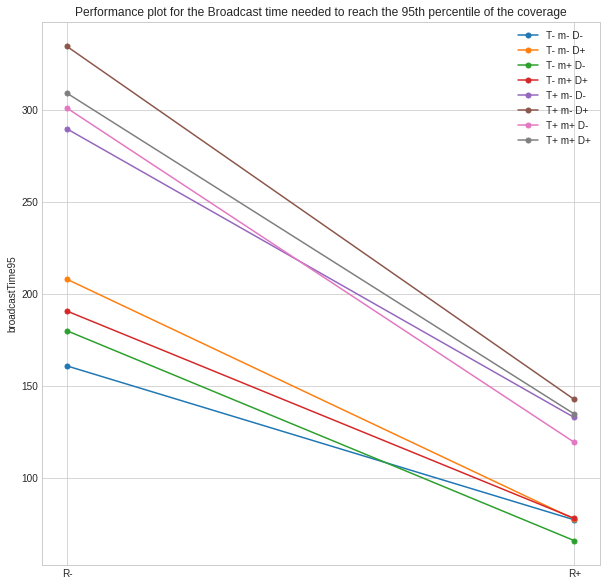

In [9]:
xarr = np.array([-1, 1])
idx = 0
for perfIndex, perfIndexDesc in perfIndexes:
    if perfIndex in skipped:
        continue
    ys = []
    fs = []
    for cfg in range(0, configsCount):
        y = np.sum(factorsMatrix.loc[cfg, ['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
        fs.append(' '.join([f + str('+' if factorsMatrix.loc[cfg][f] == 1 else '-') for f in factors[1:]]))
        ys.append(y)

    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.xticks(xarr, (factors[0] + '-', factors[0] + '+'))
    ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
    for y, lbl in zip(ys, fs):
        yarr = np.array(y)
        plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
    plt.title('Performance plot for the ' + perfIndexDesc)
    plt.ylabel(perfIndex)
    plt.legend()
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-perfplot.png')
    plt.show()
    idx += 1